In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt


## Calculate Magnetic field at position P

In [6]:

def get_B(P):
    R = 0.7
    A = [0.39, 0.4, 0.5]
    P = [0.2, -0.5]
    B = [1,0.5,2]
    G = [0, -2, 0.3]
    
    a = A
    A = []
    curr = 0
    for i in range(len(a)):
        A.append([curr, curr + float(a[i])])
        curr += float(a[i])
    
    # Step 1: check what point it is
    x = P[0]
    y = P[1]

    # Initialize output
    Bout = 0
    
    # Update output, if needed
    for k in range(len(A)):
        m1 = math.tan(math.pi/2 - float(A[k][0]))
        m2 = math.tan(math.pi/2 - float(A[k][1]))
        if y < m1*x - R and y >= m2*x - R:  # if P is in Area k
            d = math.sqrt(x**2 + (y-(-R))**2)
            h = R - d

            Bout = float(B[k])+ float(G[k])*h
            break


    return Bout

In [7]:

B = get_B([0.4, -0.3])



## Beam Rigidity

In [8]:
B_e = 3.3356*0.1

In [9]:
B_e

0.33356

## Radius

In [10]:
R = B_e/B
D = [0,1]
R

-0.9977429190736081

## New position

In [11]:
def next_point(r, P, d):
    R = np.array([[0, 1],
            [-1, 0]]) # Defining the rotation matrix in a clockwise direction
    s = 0.001
    d = np.array(d) # The direction of the point
    pc = np.matmul(R, d) # Multiplying the two matrices together to get the vector going from the point to the center

    Cx = P[0]+r*pc[0]
    Cy = P[1]+r*pc[1]
    c = np.array([Cx, Cy])

    CP = np.subtract(P, c) # Subtracting the center from the point to find CP
    theta = s/r

    R = np.array([[np.cos(-theta), -np.sin(-theta)],
            [np.sin(theta), np.cos(-theta)]]) # Defining the rotation matrix in a clockwise direction
    CP2 = np.matmul(R, CP)
    P = np.add(c,CP2) # Adding the distance from the center of the circle with the coordinates of the center to find the coordinates of the new point

    counter_R = np.array([[0, -1],
            [1, 0]]) # Defining the rotation matrix in a counter-clockwise direction
   
    D = np.matmul(counter_R, CP2)

    return P, D

In [12]:
P = [0,0]
D = [1,0]

points = []
for i in range(2):
    B = get_B(P)
    B_e = 3.3356*0.1 # Beam Rigidity
    R = B_e/B # Radius
    P, D = next_point(R,P,D)
    points.append(P)

In [13]:
math.pi*2


6.283185307179586

[0.5118122956867089, 0.5034740100348146, 0.49507500667772175, 0.48661631904008784, 0.4780989878902044, 0.46952406121193946, 0.46089259407579236, 0.45220564850907624, 0.44346429336524495, 0.4346696041923798] 
 [-1.6504534543265998, -1.6559735962664939, -1.6614009084241559, -1.6667347230158063, -1.6719743837617314, -1.6771192459670332, -1.6821686766009538, -1.6871220543747638, -1.6919787698182067, -1.6967382253544891]


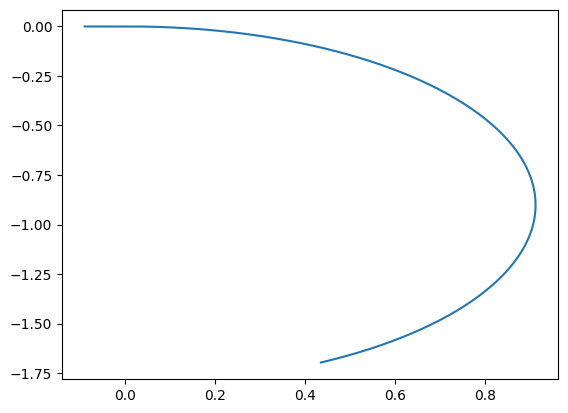

In [11]:
#R = 0.5
A = [[0, 0.39], [0.39, math.pi+0.01], [math.pi+0.01, math.pi*2]]
#P = [-0.2,0]
#B = [0.6, 0.4, 0.5]
#G = [2.0,  -2.0, 1.0]
B = 3*[0.37]
G = 3*[0]

def get_B(R, A, B, G, P):
    # Step 1: check what point it is
    x = P[0]
    y = P[1]

    # Initialize output
    Bout = 0
    # Update output, if needed

    for k in range(len(A)):
        
        m1 = math.tan(math.pi/2 - float(A[k][0]))
        m2 = math.tan(math.pi/2 - float(A[k][1]))
        
        if y < m1*x - R and y >= m2*x - R:  # if P is in Area k

            d = math.sqrt(x**2 + (y-(-R))**2)
            h = R - d
            Bout = float(B[k]) + float(G[k])*h
            break

 
    return Bout



def rot_matrix(alpha):
    R = np.array([[np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]]) # Defining the rotation matrix in a clockwise direction
    return R


def next_point(r, P, D):
    
    s = 0.01

   
    pc = np.matmul(rot_matrix(-math.pi/2), D) # Multiplying the two matrices together to get the vector going from the point to the center
    pc = r *pc 

    Cx = P[0]+pc[0]
    Cy = P[1]+pc[1]
    c = np.array([Cx, Cy])
   
    CP = np.subtract(P, c) # Subtracting the center from the point to find CP
    theta = s/r
  
    CP2 = np.matmul(rot_matrix(-theta), CP)
    P2 = np.add(c,CP2) # Adding the distance from the center of the circle with the coordinates of the center to find the coordinates of the new point

    PC2 = -CP2
    D2 = np.matmul(rot_matrix(math.pi/2), PC2)

    # Compute the magnitude of the vector
    magnitude = np.linalg.norm(D2) 
    # Normalize the vector
    D2 = D2/magnitude  

   # D2 = np.array(D2)

    return P2, D2   




def get_points(R, A, B, G, P, D, size):

    # Compute the magnitude of the vector
    magnitude = np.linalg.norm(D) 
    # Normalize the vector
    D = D/magnitude  

    B_e = 3.3356*0.1 # Beam Rigidity
    s = 0.01

    points = []
    for i in range(int(size)):
        Bout = get_B(R, A, B, G, P)
        
        if Bout != 0:
            R = B_e/Bout # Radius
            P, D = next_point(R,P,D)
        else:
            P2 = s*D
            P = np.add(P, P2)
        points.append(P)

     

    #print(str.format('{0:.15f}', P))
    # Splitting the data into x and y coordinates for plotting
    x = [point[0] for point in points]
    y = [point[1] for point in points]

    plt.plot(x,y)
    
    print(x[-10:], '\n', y[-10:])

    

    return


#next_point(1.1, [-0.1,0], [1,0])

get_points(0.7, A, B, G, [-0.1,0], [1,0], 250)